In [ ]:
# Mount Google Drive
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/processed_dataset /content/dataset
!cp -r /content/drive/MyDrive/processed_test.zip /content/
!cp -r /content/drive/MyDrive/val_indices.json /content/
!cp -r /content/drive/MyDrive/train_indices.json /content/

with zipfile.ZipFile("/content/processed_test.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/test")

Mounted at /content/drive


In [ ]:
train_image_dir = "/content/dataset/color"
train_mask_dir = "/content/dataset/label"
csv_path="/content/dataset/labels.csv"
test_image_dir = "/content/test/processed_test/color"
test_mask_dir="/content/test/processed_test/label"
test_csv_path="/content/test/processed_test/labels.csv"
train_json = "/content/train_indices.json"
val_json = "/content/val_indices.json"

In [ ]:
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Subset

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, image_dir, mask_dir, csv_path):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.df = pd.read_csv(csv_path)  # Load class labels

        self.image_paths = sorted(glob(f"{image_dir}/*.jpg"))
        self.mask_paths = sorted(glob(f"{mask_dir}/*.png"))

        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Convert to grayscale

        filename = os.path.basename(self.image_paths[idx])
        labels = self.df.loc[self.df['filename'] == filename, 'label'].values
        label = labels[0] if len(labels) > 0 else 0  # Default label = 0 if not found

        # Convert mask to numpy and ensure a single class
        mask = np.array(mask, dtype=np.uint8)
        mask[mask > 0] = label  # Ensure all nonzero pixels belong to the same class
        mask = torch.tensor(mask, dtype=torch.long)  # Convert mask to tensor

        # Transform image to tensor
        image = self.transform(image)

        return image, mask

In [ ]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        conv_output = self.conv(x)
        return conv_output, self.pool(conv_output)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)  # in_channels is upsampled + encoder_features

    def forward(self, x, encoder_features):
        x = self.upconv(x)
        x = torch.cat((x, encoder_features), dim=1)  # Skip connection concatenation
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super(UNet, self).__init__()
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.dec4 = DecoderBlock(1024, 512)
        self.dec3 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec1 = DecoderBlock(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)  #last conv to get back to original input size, 3 dim are for each class and not RGB

    def forward(self, x):
        enc1, pool1 = self.enc1(x)
        enc2, pool2 = self.enc2(pool1)
        enc3, pool3 = self.enc3(pool2)
        enc4, pool4 = self.enc4(pool3)

        bottleneck = self.bottleneck(pool4)

        dec4 = self.dec4(bottleneck, enc4)
        dec3 = self.dec3(dec4, enc3)
        dec2 = self.dec2(dec3, enc2)
        dec1 = self.dec1(dec2, enc1)

        return torch.softmax(self.final_conv(dec1), dim=1) #softmax to get probs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    epoch_loss = 0

    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)  # Move to GPU

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass

        loss = criterion(outputs, masks)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, masks in loader:
            print("Unique values in mask:", torch.unique(masks))
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    return val_loss / len(loader)


In [ ]:
import torch.optim as optim

# Define Loss Function
weights = torch.tensor([0.8, 1.5, 1.2]).to(device)  #use dataset weighting
criterion = torch.nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [ ]:
import json

# create train dataset
dataset = CatDogDataset(train_image_dir, train_mask_dir, csv_path)

# Load indices from files to keep constant train/val split
with open("train_indices.json", "r") as f:
    train_indices = json.load(f)

with open("val_indices.json", "r") as f:
    val_indices = json.load(f)

# Recreate the subsets
# Create subsets
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

# Wrap in DataLoader
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)

In [ ]:
#train loop
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)

    val_loss = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet.pth")
        print("Best model saved!")

    scheduler.step(val_loss)


Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in mask: tensor([0, 1, 2])
Unique values in ma

In [ ]:
import torch

# set save model path in my drive and save
model_save_path = "/content/drive/MyDrive/Unet_Seg_trained.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Unet_Seg_trained.pth


Unique classes in predicted mask: [0 1 2]
Unique classes in real mask: [0 1]


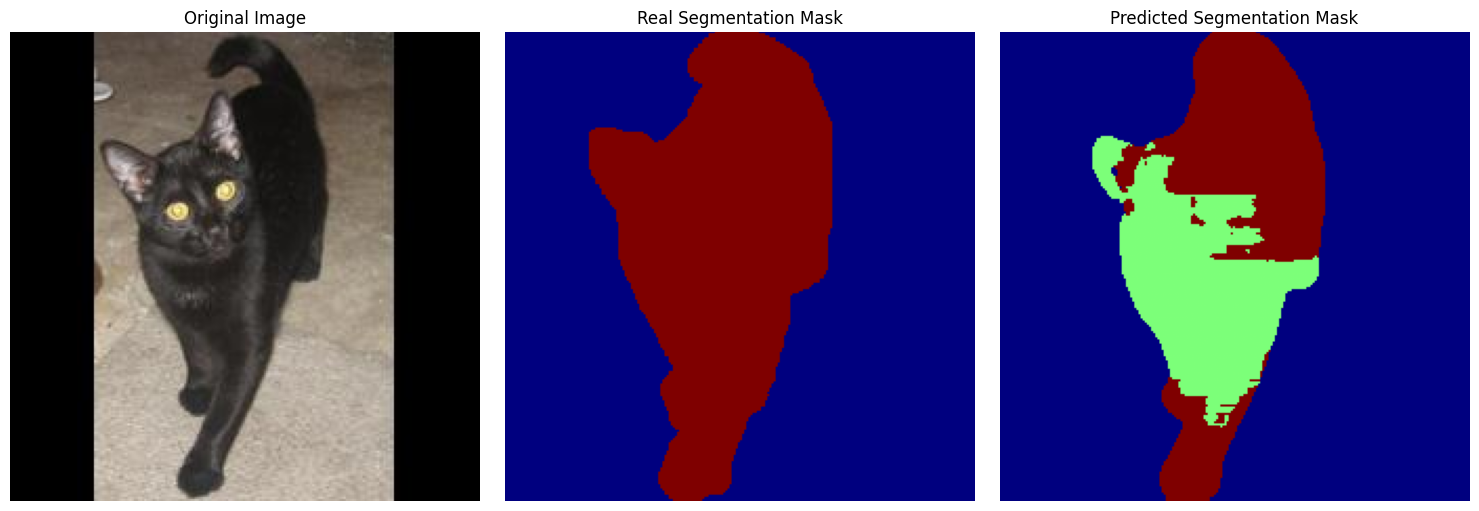

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import random

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load("best_unet.pth", map_location=device))  # Load best model
model.eval()

# Get one batch from the val_loader
val_iter = iter(val_loader)
images, masks = next(val_iter)

# Select one image and mask, send image to cpu to save gpu processing
image = images[0].to(device)
real_mask = masks[0]

# Add batch dimension, as model was trained with batch dim, here dim is 1
input_tensor = image.unsqueeze(0)

# have model predict, no grad to prevent weights from cahnging
with torch.no_grad():
    output = model(input_tensor)
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy() #converted to numpy for display

#convert to numpy for plotting
real_mask_np = real_mask.cpu().numpy()

# Print unique class values
print("Unique classes in predicted mask:", np.unique(predicted_mask))
print("Unique classes in real mask:", np.unique(real_mask_np))

# Convert image for display (to PIL image)
image_disp = to_pil_image(image.cpu())

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image_disp)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(real_mask_np, cmap="jet")
ax[1].set_title("Real Segmentation Mask")
ax[1].axis("off")

ax[2].imshow(predicted_mask, cmap="jet")
ax[2].set_title("Predicted Segmentation Mask")
ax[2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
model = UNet().to(device)  # create model instance
model.load_state_dict(torch.load("/content/drive/MyDrive/Unet_Seg_trained.pth")) #load from mydrive

<All keys matched successfully>

In [ ]:
import torch

def iou_per_class(y_true, y_pred, num_classes):
    iou_scores = []
    for cls in range(num_classes):
        intersection = torch.logical_and(y_true == cls, y_pred == cls).float().sum()
        union = torch.logical_or(y_true == cls, y_pred == cls).float().sum()
        iou_scores.append((intersection / union).item() if union > 0 else 0.0)
    return iou_scores  # List of IoU scores for each class

def dice_per_class(y_true, y_pred, num_classes):
    dice_scores = []
    for cls in range(num_classes):
        intersection = torch.logical_and(y_true == cls, y_pred == cls).float().sum()
        denominator = (y_true.eq(cls).float().sum() + y_pred.eq(cls).float().sum())
        dice_scores.append((2.0 * intersection / denominator).item() if denominator > 0 else 0.0)
    return dice_scores  # List of Dice scores for each class

def pixel_accuracy_per_class(y_true, y_pred, num_classes):
    acc_scores = []
    for cls in range(num_classes):
        mask_cls = (y_true == cls)
        acc_scores.append((y_pred[mask_cls] == cls).float().mean().item() if mask_cls.sum() > 0 else 0.0)
    return acc_scores  # List of Accuracy scores for each class


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def evaluate_model_per_class(model, test_loader, num_classes, device="cuda"):
    model.eval()
    iou_scores_per_class = [[] for _ in range(num_classes)]
    dice_scores_per_class = [[] for _ in range(num_classes)]
    accuracy_scores_per_class = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Convert to class labels

            for i in range(len(images)):
                iou_scores = iou_per_class(masks[i], preds[i], num_classes)
                dice_scores = dice_per_class(masks[i], preds[i], num_classes)
                acc_scores = pixel_accuracy_per_class(masks[i], preds[i], num_classes)

                for cls in range(num_classes):
                    iou_scores_per_class[cls].append(iou_scores[cls])
                    dice_scores_per_class[cls].append(dice_scores[cls])
                    accuracy_scores_per_class[cls].append(acc_scores[cls])

    # Compute mean per-class metrics (handle empty lists)
    mean_iou_per_class = [torch.mean(torch.tensor(scores)).item() if scores else 0.0 for scores in iou_scores_per_class]
    mean_dice_per_class = [torch.mean(torch.tensor(scores)).item() if scores else 0.0 for scores in dice_scores_per_class]
    mean_accuracy_per_class = [torch.mean(torch.tensor(scores)).item() if scores else 0.0 for scores in accuracy_scores_per_class]

    # Compute overall mean (average over classes)
    mean_iou = sum(mean_iou_per_class) / num_classes
    mean_dice = sum(mean_dice_per_class) / num_classes
    mean_accuracy = sum(mean_accuracy_per_class) / num_classes

    print(f"Mean IoU Per Class: {mean_iou_per_class}")
    print(f"Mean Dice Per Class: {mean_dice_per_class}")
    print(f"Mean Accuracy Per Class: {mean_accuracy_per_class}")
    print(f"Overall Mean IoU: {mean_iou:.4f} (Baseline: 0.33)")
    print(f"Overall Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Overall Mean Pixel Accuracy: {mean_accuracy:.4f}")

    return mean_iou_per_class, mean_dice_per_class, mean_accuracy_per_class, mean_iou, mean_dice, mean_accuracy


In [ ]:
#create test set and evaluate on it
num_classes = 3

Test_Set = CatDogDataset(test_image_dir, test_mask_dir, test_csv_path)
Test_loader = DataLoader(Test_Set, batch_size=8, shuffle=False)
evaluate_model_per_class(model,Test_loader, num_classes)


Mean IoU Per Class: [0.917149543762207, 0.22054123878479004, 0.5352699160575867]
Mean Dice Per Class: [0.9548505544662476, 0.2511458992958069, 0.5860439538955688]
Mean Accuracy Per Class: [0.9559009671211243, 0.2408429980278015, 0.5789798498153687]
Overall Mean IoU: 0.5577 (Baseline: 0.33)
Overall Mean Dice Coefficient: 0.5973
Overall Mean Pixel Accuracy: 0.5919


([0.917149543762207, 0.22054123878479004, 0.5352699160575867],
 [0.9548505544662476, 0.2511458992958069, 0.5860439538955688],
 [0.9559009671211243, 0.2408429980278015, 0.5789798498153687],
 0.557653566201528,
 0.5973468025525411,
 0.5919079383214315)